In [1]:
from scripts.bloch import *
import qiskit
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile, assemble
from qiskit.visualization import *

### Single Neuron Activation Function
---

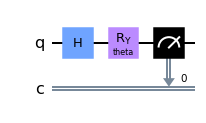

In [2]:
# ---- single quron ---------------------
sigma_1 = qiskit.QuantumCircuit(1,1)
theta = qiskit.circuit.Parameter('theta')
sigma_1.h(0)
sigma_1.ry(theta, 0)
sigma_1.measure(0,0)
# ---------------------------------------

sigma_1.draw('mpl')

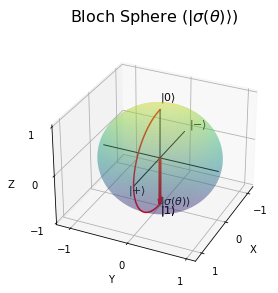

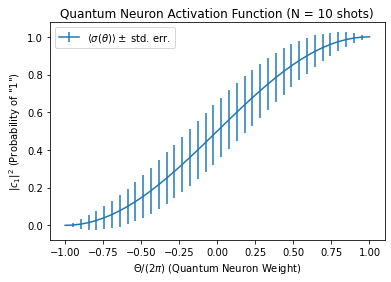

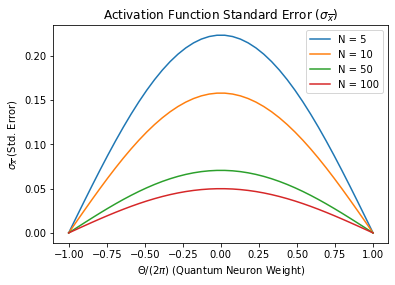

In [10]:
thetas = np.linspace(-1.0, 1.0, 40)
default_n_shots = 10

kets = np.array([
    [np.cos(t*np.pi/4. + np.pi/4.), np.sin(t*np.pi/4. + np.pi/4.)]
    for t in thetas
])
plot_bloch_trajectory(kets, name=r'$|\sigma(\theta)\rangle$')

ket_probs = np.real(kets * np.conj(kets))

unit_std_err = np.array([
    np.abs(np.sin(t*np.pi/4. + np.pi/4.)*np.cos(t*np.pi/4. + np.pi/4.))
    for t in thetas
])

plt.figure()
plt.title(f'Quantum Neuron Activation Function (N = {default_n_shots} shots)')
#plt.plot(thetas, ket_probs[:,0], label=r'$\langle \sigma(\theta) \rangle \pm $ std. err.')
plt.errorbar(thetas,ket_probs[:,1],
             unit_std_err/np.sqrt(default_n_shots),
             label=r'$\langle \sigma(\theta) \rangle \pm $ std. err.')
plt.xlabel(r'$\Theta/(2\pi)$ (Quantum Neuron Weight)')
plt.ylabel(r'$|c_1|^2$ (Probability of "1")')
plt.legend()
plt.show()

plt.figure()
plt.title(r'Activation Function Standard Error ($\sigma_{\overline{x}}$)')
for n in [5, 10, 50, 100]:
    plt.plot(thetas, unit_std_err/np.sqrt(n), 
             label=f'N = {n}')
plt.xlabel(r'$\Theta/(2\pi)$ (Quantum Neuron Weight)')
plt.ylabel(r'$\sigma_{\overline{x}}$ (Std. Error)')
plt.legend()
plt.show()


### Entangled Activation Functions
---

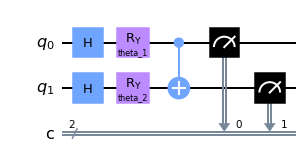

In [4]:
# ---- paired qurons --------------------
sigma_2 = qiskit.QuantumCircuit(2,2)
theta_1 = qiskit.circuit.Parameter('theta_1')
theta_2 = qiskit.circuit.Parameter('theta_2')
sigma_2.h([0,1])
sigma_2.ry(theta_1, 0)
sigma_2.ry(theta_2, 1)
sigma_2.cnot(0,1)
sigma_2.measure([0,1],[0,1])
# ---------------------------------------

sigma_2.draw('mpl')

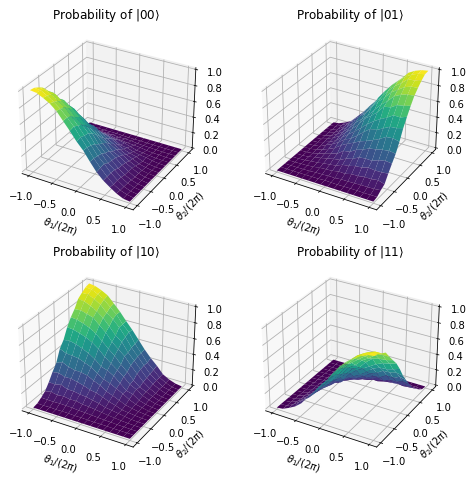

In [5]:
thetas = np.linspace(-1.0, 1.0, 16)
n_shots = 2000


T_1, T_2 = np.meshgrid(thetas, thetas)

backend = qiskit.Aer.get_backend('qasm_simulator')
t_sigma_2 = transpile(sigma_2, QasmSimulator())
qobj = assemble(t_sigma_2,
                shots=n_shots,
                parameter_binds = [
                    {  theta_1: t[0]*np.pi/2., 
                       theta_2: t[1]*np.pi/2.  }
                    for t in zip(np.ravel(T_1),np.ravel(T_2))
                ])
job = backend.run(qobj)
result = job.result().get_counts()

keys = ['00','01','10','11']
Z = { k : [] for k in keys }
for r in result:
    # ensure every key is present
    for k in keys:
        if k not in r:
            r[k] = 0
    
    for k, v in r.items():
        Z[k].append(v/n_shots)

fig = plt.figure(figsize=(8,8))
for i, (key, Z_i) in enumerate(Z.items()):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    Z_mesh = np.array(Z_i).reshape(T_1.shape)
    ax.plot_surface(T_1,T_2, Z_mesh, cmap='viridis', vmin=0., vmax=1.0)
    ax.set_title(r'Probability of $|$' + f'{key}' + r'$\rangle$')
    ax.set_xlabel(r'$\theta_1/(2\pi)$')
    ax.set_ylabel(r'$\theta_2/(2\pi)$')
plt.show()


### Quron
---

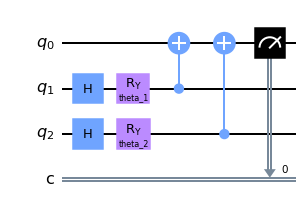

In [6]:
# ---- paired qurons --------------------
quron = qiskit.QuantumCircuit(3,1)
theta_1 = qiskit.circuit.Parameter('theta_1')
theta_2 = qiskit.circuit.Parameter('theta_2')
quron.h([1,2])
quron.ry(theta_1, 1)
quron.ry(theta_2, 2)
quron.cnot(1,0)
quron.cnot(2,0)
quron.measure(0,0)
# ---------------------------------------

quron.draw('mpl')

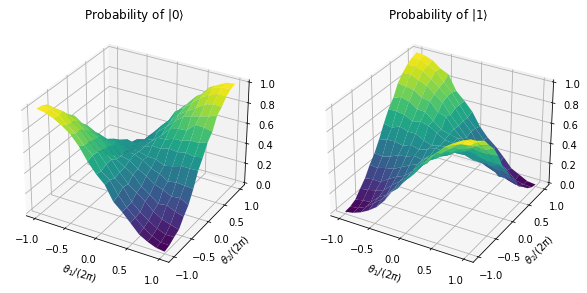

In [8]:
thetas = np.linspace(-1.0, 1.0, 16)
n_shots = 1000


T_1, T_2 = np.meshgrid(thetas, thetas)

backend = qiskit.Aer.get_backend('qasm_simulator')
t_quron = transpile(quron, QasmSimulator())
qobj = assemble(t_quron,
                shots=n_shots,
                parameter_binds = [
                    {  theta_1: t[0]*np.pi/2., 
                       theta_2: t[1]*np.pi/2.  }
                    for t in zip(np.ravel(T_1),np.ravel(T_2))
                ])
job = backend.run(qobj)
result = job.result().get_counts()

keys = ['0', '1']
Z = { k : [] for k in keys }
for r in result:
    # ensure every key is present
    for k in keys:
        if k not in r:
            r[k] = 0
    
    for k, v in r.items():
        Z[k].append(v/n_shots)
        
fig = plt.figure(figsize=(10,10))
for i, (key, Z_i) in enumerate(Z.items()):
    ax = fig.add_subplot(1,2,i+1, projection='3d')
    Z_mesh = np.array(Z_i).reshape(T_1.shape)
    ax.plot_surface(T_1,T_2, Z_mesh, cmap='viridis', vmin=0., vmax=1.0)
    ax.set_title(r'Probability of $|$' + f'{key}' + r'$\rangle$')
    ax.set_xlabel(r'$\theta_1/(2\pi)$')
    ax.set_ylabel(r'$\theta_2/(2\pi)$')
plt.show()